In [ ]:
# Install dependencies
!pip install gymnasium
!pip install torch torchvision
!git clone https://github.com/facebookresearch/jepa.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [2]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 120.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2025.3.1 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have nu

In [1]:
def compute_energy(theta, omega, m=1.0, l=1.0, g=9.81):
    """
    Compute the total mechanical energy of the pendulum
    E = 0.5 * m * l^2 * omega^2 + m * g * l * (1 - cos(theta))
    """
    kinetic = 0.5 * m * (l**2) * omega**2
    potential = m * g * l * (1 - np.cos(theta))
    return kinetic + potential


In [2]:
def plot_energy_per_episode(dataset, episode_length=100):
    thetas = []
    omegas = []
    energies = []
    num_episodes = len(dataset) // episode_length

    for ep in range(num_episodes):
        ep_thetas = []
        ep_omegas = []
        for i in range(episode_length):
            idx = ep * episode_length + i
            _, label = dataset[idx]
            ep_thetas.append(label[0].item())
            ep_omegas.append(label[1].item())
        theta_np = np.array(ep_thetas)
        omega_np = np.array(ep_omegas)
        energy = compute_energy(theta_np, omega_np)
        energies.append(energy)

    # Plot each episode separately
    plt.figure(figsize=(12, 4))
    for ep_energy in energies:
        plt.plot(ep_energy, alpha=0.7)
    plt.xlabel("Time Step (within episode)")
    plt.ylabel("Energy (J)")
    plt.title("Pendulum Energy per Episode")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("energy_per_episode.png")
    plt.show()


In [3]:
def plot_true_phase_space(dataset, num_samples=500):
    theta_vals = []
    omega_vals = []
    for i in range(min(num_samples, len(dataset))):
        _, label = dataset[i]
        theta_vals.append(label[0].item())
        omega_vals.append(label[1].item())

    plt.figure(figsize=(6, 5))
    plt.plot(theta_vals, omega_vals, '.', alpha=0.3)
    plt.xlabel("Theta (rad)")
    plt.ylabel("Theta dot (rad/s)")
    plt.title("True Phase Space Trajectory (θ vs θ̇)")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("true_phase_space.png")
    plt.show()


In [4]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm

def analyze_vjepa_latent_phase_relation(model, dataset, batch_size=64, num_samples=500):
    """
    Analyze how V-JEPA latent embeddings relate to physical phase space variables (theta, theta_dot).
    This assumes access to the latent features before the prediction head.

    Args:
        model: trained V-JEPA model
        dataset: PendulumDataset object with access to raw images and (theta, omega) tuples
        batch_size: batch size for DataLoader
        num_samples: number of samples to analyze
    """
    model.eval()

    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    latent_features = []
    theta_list = []
    omega_list = []

    count = 0
    for imgs, labels in tqdm(loader, desc="Extracting embeddings"):
        imgs = imgs.to(next(model.parameters()).device)
        thetas, omegas = labels[:, 0], labels[:, 1]

        with torch.no_grad():
            x = model.patch_embed(imgs) + model.pos_embed  # [B, N, D]
            x = model.context_encoder(x)  # [B, N, D]
            pooled = x.mean(dim=1)  # average pooling over patches -> [B, D]
            latent_features.append(pooled.cpu())

        theta_list.extend(thetas.numpy())
        omega_list.extend(omegas.numpy())

        count += imgs.size(0)
        if count >= num_samples:
            break

    latent_features = torch.cat(latent_features, dim=0).numpy()[:num_samples]
    theta_array = np.array(theta_list[:num_samples]).reshape(-1, 1)
    omega_array = np.array(omega_list[:num_samples]).reshape(-1, 1)

    # Fit regressors
    reg_theta = LinearRegression().fit(latent_features, theta_array)
    reg_omega = LinearRegression().fit(latent_features, omega_array)

    theta_pred = reg_theta.predict(latent_features)
    omega_pred = reg_omega.predict(latent_features)

    # Metrics
    r2_theta = r2_score(theta_array, theta_pred)
    r2_omega = r2_score(omega_array, omega_pred)
    mse_theta = mean_squared_error(theta_array, theta_pred)
    mse_omega = mean_squared_error(omega_array, omega_pred)

    print(f"\nLatent -> Theta R²: {r2_theta:.4f}, MSE: {mse_theta:.4f}")
    print(f"Latent -> Omega R²: {r2_omega:.4f}, MSE: {mse_omega:.4f}")

    # Scatter plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(theta_array, theta_pred, alpha=0.6)
    plt.xlabel("True θ")
    plt.ylabel("Predicted θ from Latents")
    plt.title("Latent Embedding → Theta")

    plt.subplot(1, 2, 2)
    plt.scatter(omega_array, omega_pred, alpha=0.6)
    plt.xlabel("True θ̇")
    plt.ylabel("Predicted θ̇ from Latents")
    plt.title("Latent Embedding → Theta_dot")

    plt.tight_layout()
    plt.show()


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Using device: cuda
Generating synthetic pendulum data...


100%|██████████| 50/50 [00:00<00:00, 50.63it/s]


Dataset created with 5000 images
Starting training...


Epoch 1/10:   8%|▊         | 12/157 [00:01<00:11, 12.81batch/s, loss=3.99]

Epoch 1, Batch 10/157, Loss: 4.0718


Epoch 1/10:  14%|█▍        | 22/157 [00:01<00:09, 13.68batch/s, loss=3.61]

Epoch 1, Batch 20/157, Loss: 3.6996


Epoch 1/10:  20%|██        | 32/157 [00:02<00:08, 13.90batch/s, loss=3.23]

Epoch 1, Batch 30/157, Loss: 3.3097


Epoch 1/10:  27%|██▋       | 42/157 [00:03<00:08, 13.73batch/s, loss=2.81]

Epoch 1, Batch 40/157, Loss: 2.8867


Epoch 1/10:  33%|███▎      | 52/157 [00:03<00:07, 13.82batch/s, loss=2.42]

Epoch 1, Batch 50/157, Loss: 2.5086


Epoch 1/10:  39%|███▉      | 62/157 [00:04<00:06, 13.94batch/s, loss=2.1]

Epoch 1, Batch 60/157, Loss: 2.1680


Epoch 1/10:  46%|████▌     | 72/157 [00:05<00:06, 13.86batch/s, loss=1.85]

Epoch 1, Batch 70/157, Loss: 1.8824


Epoch 1/10:  52%|█████▏    | 82/157 [00:06<00:05, 13.83batch/s, loss=1.67]

Epoch 1, Batch 80/157, Loss: 1.6852


Epoch 1/10:  59%|█████▊    | 92/157 [00:06<00:04, 13.78batch/s, loss=1.52]

Epoch 1, Batch 90/157, Loss: 1.5553


Epoch 1/10:  65%|██████▍   | 102/157 [00:07<00:04, 13.69batch/s, loss=1.42]

Epoch 1, Batch 100/157, Loss: 1.4554


Epoch 1/10:  71%|███████▏  | 112/157 [00:08<00:03, 13.87batch/s, loss=1.35]

Epoch 1, Batch 110/157, Loss: 1.3771


Epoch 1/10:  78%|███████▊  | 122/157 [00:09<00:02, 13.72batch/s, loss=1.32]

Epoch 1, Batch 120/157, Loss: 1.3246


Epoch 1/10:  84%|████████▍ | 132/157 [00:09<00:01, 13.99batch/s, loss=1.29]

Epoch 1, Batch 130/157, Loss: 1.2895


Epoch 1/10:  90%|█████████ | 142/157 [00:10<00:01, 14.08batch/s, loss=1.27]

Epoch 1, Batch 140/157, Loss: 1.2769


Epoch 1/10:  97%|█████████▋| 152/157 [00:11<00:00, 13.08batch/s, loss=1.26]

Epoch 1, Batch 150/157, Loss: 1.2582


Epoch 1/10: 100%|██████████| 157/157 [00:11<00:00, 13.72batch/s, loss=1.24]


Epoch 1 completed, Avg Loss: 2.2063


Epoch 2/10:   8%|▊         | 12/157 [00:00<00:10, 13.87batch/s, loss=1.23]

Epoch 2, Batch 10/157, Loss: 1.2550


Epoch 2/10:  14%|█▍        | 22/157 [00:01<00:09, 13.63batch/s, loss=1.23]

Epoch 2, Batch 20/157, Loss: 1.2271


Epoch 2/10:  20%|██        | 32/157 [00:02<00:09, 13.46batch/s, loss=1.22]

Epoch 2, Batch 30/157, Loss: 1.2151


Epoch 2/10:  27%|██▋       | 42/157 [00:03<00:08, 13.95batch/s, loss=1.21]

Epoch 2, Batch 40/157, Loss: 1.2103


Epoch 2/10:  33%|███▎      | 52/157 [00:03<00:07, 14.08batch/s, loss=1.21]

Epoch 2, Batch 50/157, Loss: 1.2129


Epoch 2/10:  39%|███▉      | 62/157 [00:04<00:06, 13.85batch/s, loss=1.18]

Epoch 2, Batch 60/157, Loss: 1.1945


Epoch 2/10:  46%|████▌     | 72/157 [00:05<00:06, 13.89batch/s, loss=1.17]

Epoch 2, Batch 70/157, Loss: 1.1831


Epoch 2/10:  52%|█████▏    | 82/157 [00:06<00:05, 13.90batch/s, loss=1.17]

Epoch 2, Batch 80/157, Loss: 1.1655


Epoch 2/10:  59%|█████▊    | 92/157 [00:06<00:04, 13.97batch/s, loss=1.16]

Epoch 2, Batch 90/157, Loss: 1.1524


Epoch 2/10:  65%|██████▍   | 102/157 [00:07<00:03, 13.97batch/s, loss=1.13]

Epoch 2, Batch 100/157, Loss: 1.1363


Epoch 2/10:  71%|███████▏  | 112/157 [00:08<00:03, 13.96batch/s, loss=1.14]

Epoch 2, Batch 110/157, Loss: 1.1319


Epoch 2/10:  78%|███████▊  | 122/157 [00:08<00:02, 13.94batch/s, loss=1.11]

Epoch 2, Batch 120/157, Loss: 1.1227


Epoch 2/10:  84%|████████▍ | 132/157 [00:09<00:01, 13.91batch/s, loss=1.11]

Epoch 2, Batch 130/157, Loss: 1.1021


Epoch 2/10:  90%|█████████ | 142/157 [00:10<00:01, 13.87batch/s, loss=1.11]

Epoch 2, Batch 140/157, Loss: 1.1029


Epoch 2/10:  97%|█████████▋| 152/157 [00:11<00:00, 13.63batch/s, loss=1.11]

Epoch 2, Batch 150/157, Loss: 1.1008


Epoch 2/10: 100%|██████████| 157/157 [00:11<00:00, 13.87batch/s, loss=1.08]


Epoch 2 completed, Avg Loss: 1.1702


Epoch 3/10:   8%|▊         | 12/157 [00:00<00:10, 13.87batch/s, loss=1.09]

Epoch 3, Batch 10/157, Loss: 1.0879


Epoch 3/10:  14%|█▍        | 22/157 [00:01<00:09, 14.06batch/s, loss=1.09]

Epoch 3, Batch 20/157, Loss: 1.0849


Epoch 3/10:  20%|██        | 32/157 [00:02<00:08, 14.03batch/s, loss=1.08]

Epoch 3, Batch 30/157, Loss: 1.0806


Epoch 3/10:  27%|██▋       | 42/157 [00:03<00:08, 14.01batch/s, loss=1.06]

Epoch 3, Batch 40/157, Loss: 1.0733


Epoch 3/10:  33%|███▎      | 52/157 [00:03<00:07, 14.08batch/s, loss=1.07]

Epoch 3, Batch 50/157, Loss: 1.0902


Epoch 3/10:  39%|███▉      | 62/157 [00:04<00:06, 14.00batch/s, loss=1.06]

Epoch 3, Batch 60/157, Loss: 1.0716


Epoch 3/10:  46%|████▌     | 72/157 [00:05<00:06, 13.93batch/s, loss=1.07]

Epoch 3, Batch 70/157, Loss: 1.0681


Epoch 3/10:  52%|█████▏    | 82/157 [00:05<00:05, 13.83batch/s, loss=1.07]

Epoch 3, Batch 80/157, Loss: 1.0636


Epoch 3/10:  59%|█████▊    | 92/157 [00:06<00:04, 13.88batch/s, loss=1.07]

Epoch 3, Batch 90/157, Loss: 1.0698


Epoch 3/10:  65%|██████▍   | 102/157 [00:07<00:03, 13.90batch/s, loss=1.06]

Epoch 3, Batch 100/157, Loss: 1.0717


Epoch 3/10:  71%|███████▏  | 112/157 [00:08<00:03, 13.68batch/s, loss=1.05]

Epoch 3, Batch 110/157, Loss: 1.0647


Epoch 3/10:  78%|███████▊  | 122/157 [00:08<00:02, 13.96batch/s, loss=1.06]

Epoch 3, Batch 120/157, Loss: 1.0603


Epoch 3/10:  84%|████████▍ | 132/157 [00:09<00:01, 13.92batch/s, loss=1.06]

Epoch 3, Batch 130/157, Loss: 1.0600


Epoch 3/10:  90%|█████████ | 142/157 [00:10<00:01, 13.54batch/s, loss=1.05]

Epoch 3, Batch 140/157, Loss: 1.0658


Epoch 3/10:  97%|█████████▋| 152/157 [00:11<00:00, 13.85batch/s, loss=1.04]

Epoch 3, Batch 150/157, Loss: 1.0521


Epoch 3/10: 100%|██████████| 157/157 [00:11<00:00, 13.95batch/s, loss=1.08]


Epoch 3 completed, Avg Loss: 1.0711


Epoch 4/10:   8%|▊         | 12/157 [00:00<00:10, 13.44batch/s, loss=1.06]

Epoch 4, Batch 10/157, Loss: 1.0660


Epoch 4/10:  14%|█▍        | 22/157 [00:01<00:09, 14.00batch/s, loss=1.06]

Epoch 4, Batch 20/157, Loss: 1.0513


Epoch 4/10:  20%|██        | 32/157 [00:02<00:08, 14.00batch/s, loss=1.05]

Epoch 4, Batch 30/157, Loss: 1.0594


Epoch 4/10:  27%|██▋       | 42/157 [00:03<00:08, 13.43batch/s, loss=1.05]

Epoch 4, Batch 40/157, Loss: 1.0521


Epoch 4/10:  33%|███▎      | 52/157 [00:03<00:08, 12.93batch/s, loss=1.05]

Epoch 4, Batch 50/157, Loss: 1.0482


Epoch 4/10:  39%|███▉      | 62/157 [00:04<00:06, 13.75batch/s, loss=1.05]

Epoch 4, Batch 60/157, Loss: 1.0497


Epoch 4/10:  46%|████▌     | 72/157 [00:05<00:06, 13.74batch/s, loss=1.06]

Epoch 4, Batch 70/157, Loss: 1.0476


Epoch 4/10:  52%|█████▏    | 82/157 [00:06<00:05, 13.57batch/s, loss=1.04]

Epoch 4, Batch 80/157, Loss: 1.0601


Epoch 4/10:  59%|█████▊    | 92/157 [00:06<00:04, 13.93batch/s, loss=1.05]

Epoch 4, Batch 90/157, Loss: 1.0465


Epoch 4/10:  65%|██████▍   | 102/157 [00:07<00:03, 13.85batch/s, loss=1.05]

Epoch 4, Batch 100/157, Loss: 1.0601


Epoch 4/10:  71%|███████▏  | 112/157 [00:08<00:03, 13.94batch/s, loss=1.04]

Epoch 4, Batch 110/157, Loss: 1.0520


Epoch 4/10:  78%|███████▊  | 122/157 [00:08<00:02, 14.00batch/s, loss=1.05]

Epoch 4, Batch 120/157, Loss: 1.0441


Epoch 4/10:  84%|████████▍ | 132/157 [00:09<00:01, 13.94batch/s, loss=1.04]

Epoch 4, Batch 130/157, Loss: 1.0444


Epoch 4/10:  90%|█████████ | 142/157 [00:10<00:01, 13.82batch/s, loss=1.05]

Epoch 4, Batch 140/157, Loss: 1.0388


Epoch 4/10:  97%|█████████▋| 152/157 [00:11<00:00, 13.52batch/s, loss=1.04]

Epoch 4, Batch 150/157, Loss: 1.0468


Epoch 4/10: 100%|██████████| 157/157 [00:11<00:00, 13.79batch/s, loss=1.05]


Epoch 4 completed, Avg Loss: 1.0491


Epoch 5/10:   8%|▊         | 12/157 [00:00<00:10, 13.69batch/s, loss=1.04]

Epoch 5, Batch 10/157, Loss: 1.0406


Epoch 5/10:  14%|█▍        | 22/157 [00:01<00:09, 13.97batch/s, loss=1.04]

Epoch 5, Batch 20/157, Loss: 1.0462


Epoch 5/10:  20%|██        | 32/157 [00:02<00:08, 13.98batch/s, loss=1.04]

Epoch 5, Batch 30/157, Loss: 1.0314


Epoch 5/10:  27%|██▋       | 42/157 [00:03<00:08, 13.57batch/s, loss=1.04]

Epoch 5, Batch 40/157, Loss: 1.0369


Epoch 5/10:  33%|███▎      | 52/157 [00:03<00:07, 13.61batch/s, loss=1.03]

Epoch 5, Batch 50/157, Loss: 1.0414


Epoch 5/10:  39%|███▉      | 62/157 [00:04<00:07, 13.08batch/s, loss=1.02]

Epoch 5, Batch 60/157, Loss: 1.0356


Epoch 5/10:  46%|████▌     | 72/157 [00:05<00:06, 13.80batch/s, loss=1.04]

Epoch 5, Batch 70/157, Loss: 1.0306


Epoch 5/10:  52%|█████▏    | 82/157 [00:06<00:05, 13.09batch/s, loss=1.03]

Epoch 5, Batch 80/157, Loss: 1.0405


Epoch 5/10:  59%|█████▊    | 92/157 [00:06<00:04, 13.78batch/s, loss=1.04]

Epoch 5, Batch 90/157, Loss: 1.0298


Epoch 5/10:  65%|██████▍   | 102/157 [00:07<00:04, 13.53batch/s, loss=1.03]

Epoch 5, Batch 100/157, Loss: 1.0284


Epoch 5/10:  71%|███████▏  | 112/157 [00:08<00:03, 13.64batch/s, loss=1.03]

Epoch 5, Batch 110/157, Loss: 1.0364


Epoch 5/10:  78%|███████▊  | 122/157 [00:09<00:02, 13.27batch/s, loss=1.05]

Epoch 5, Batch 120/157, Loss: 1.0292


Epoch 5/10:  84%|████████▍ | 132/157 [00:09<00:01, 13.43batch/s, loss=1.04]

Epoch 5, Batch 130/157, Loss: 1.0321


Epoch 5/10:  90%|█████████ | 142/157 [00:10<00:01, 13.35batch/s, loss=1.04]

Epoch 5, Batch 140/157, Loss: 1.0326


Epoch 5/10:  97%|█████████▋| 152/157 [00:11<00:00, 13.83batch/s, loss=1.03]

Epoch 5, Batch 150/157, Loss: 1.0359


Epoch 5/10: 100%|██████████| 157/157 [00:11<00:00, 13.62batch/s, loss=1.03]


Epoch 5 completed, Avg Loss: 1.0379


Epoch 6/10:   8%|▊         | 12/157 [00:00<00:11, 13.15batch/s, loss=1.03]

Epoch 6, Batch 10/157, Loss: 1.0458


Epoch 6/10:  14%|█▍        | 22/157 [00:01<00:09, 13.84batch/s, loss=1.03]

Epoch 6, Batch 20/157, Loss: 1.0239


Epoch 6/10:  20%|██        | 32/157 [00:02<00:08, 13.89batch/s, loss=1.03]

Epoch 6, Batch 30/157, Loss: 1.0303


Epoch 6/10:  27%|██▋       | 42/157 [00:03<00:08, 13.95batch/s, loss=1.03]

Epoch 6, Batch 40/157, Loss: 1.0304


Epoch 6/10:  33%|███▎      | 52/157 [00:03<00:07, 13.99batch/s, loss=1.04]

Epoch 6, Batch 50/157, Loss: 1.0389


Epoch 6/10:  39%|███▉      | 62/157 [00:04<00:06, 13.77batch/s, loss=1.03]

Epoch 6, Batch 60/157, Loss: 1.0320


Epoch 6/10:  46%|████▌     | 72/157 [00:05<00:06, 13.92batch/s, loss=1.03]

Epoch 6, Batch 70/157, Loss: 1.0289


Epoch 6/10:  52%|█████▏    | 82/157 [00:06<00:05, 13.56batch/s, loss=1.03]

Epoch 6, Batch 80/157, Loss: 1.0270


Epoch 6/10:  59%|█████▊    | 92/157 [00:06<00:04, 13.88batch/s, loss=1.03]

Epoch 6, Batch 90/157, Loss: 1.0374


Epoch 6/10:  65%|██████▍   | 102/157 [00:07<00:03, 13.89batch/s, loss=1.03]

Epoch 6, Batch 100/157, Loss: 1.0377


Epoch 6/10:  71%|███████▏  | 112/157 [00:08<00:03, 13.84batch/s, loss=1.03]

Epoch 6, Batch 110/157, Loss: 1.0320


Epoch 6/10:  78%|███████▊  | 122/157 [00:08<00:02, 13.93batch/s, loss=1.03]

Epoch 6, Batch 120/157, Loss: 1.0272


Epoch 6/10:  84%|████████▍ | 132/157 [00:09<00:01, 13.96batch/s, loss=1.02]

Epoch 6, Batch 130/157, Loss: 1.0288


Epoch 6/10:  90%|█████████ | 142/157 [00:10<00:01, 13.34batch/s, loss=1.03]

Epoch 6, Batch 140/157, Loss: 1.0245


Epoch 6/10:  97%|█████████▋| 152/157 [00:11<00:00, 13.45batch/s, loss=1.03]

Epoch 6, Batch 150/157, Loss: 1.0307


Epoch 6/10: 100%|██████████| 157/157 [00:11<00:00, 13.82batch/s, loss=1.02]


Epoch 6 completed, Avg Loss: 1.0300


Epoch 7/10:   8%|▊         | 12/157 [00:00<00:10, 13.50batch/s, loss=1.02]

Epoch 7, Batch 10/157, Loss: 1.0329


Epoch 7/10:  14%|█▍        | 22/157 [00:01<00:10, 13.00batch/s, loss=1.02]

Epoch 7, Batch 20/157, Loss: 1.0244


Epoch 7/10:  20%|██        | 32/157 [00:02<00:09, 13.75batch/s, loss=1.03]

Epoch 7, Batch 30/157, Loss: 1.0248


Epoch 7/10:  27%|██▋       | 42/157 [00:03<00:08, 13.72batch/s, loss=1.02]

Epoch 7, Batch 40/157, Loss: 1.0325


Epoch 7/10:  33%|███▎      | 52/157 [00:03<00:07, 13.89batch/s, loss=1.03]

Epoch 7, Batch 50/157, Loss: 1.0238


Epoch 7/10:  39%|███▉      | 62/157 [00:04<00:06, 13.95batch/s, loss=1.02]

Epoch 7, Batch 60/157, Loss: 1.0265


Epoch 7/10:  46%|████▌     | 72/157 [00:05<00:06, 13.84batch/s, loss=1.02]

Epoch 7, Batch 70/157, Loss: 1.0281


Epoch 7/10:  52%|█████▏    | 82/157 [00:06<00:05, 13.82batch/s, loss=1.02]

Epoch 7, Batch 80/157, Loss: 1.0276


Epoch 7/10:  59%|█████▊    | 92/157 [00:06<00:04, 14.03batch/s, loss=1.03]

Epoch 7, Batch 90/157, Loss: 1.0253


Epoch 7/10:  65%|██████▍   | 102/157 [00:07<00:03, 13.88batch/s, loss=1.02]

Epoch 7, Batch 100/157, Loss: 1.0217


Epoch 7/10:  71%|███████▏  | 112/157 [00:08<00:03, 13.53batch/s, loss=1.02]

Epoch 7, Batch 110/157, Loss: 1.0236


Epoch 7/10:  78%|███████▊  | 122/157 [00:08<00:02, 13.87batch/s, loss=1.02]

Epoch 7, Batch 120/157, Loss: 1.0255


Epoch 7/10:  84%|████████▍ | 132/157 [00:09<00:01, 13.70batch/s, loss=1.02]

Epoch 7, Batch 130/157, Loss: 1.0303


Epoch 7/10:  90%|█████████ | 142/157 [00:10<00:01, 13.84batch/s, loss=1.01]

Epoch 7, Batch 140/157, Loss: 1.0210


Epoch 7/10:  97%|█████████▋| 152/157 [00:11<00:00, 13.40batch/s, loss=1.03]

Epoch 7, Batch 150/157, Loss: 1.0309


Epoch 7/10: 100%|██████████| 157/157 [00:11<00:00, 13.73batch/s, loss=1.02]


Epoch 7 completed, Avg Loss: 1.0253


Epoch 8/10:   8%|▊         | 12/157 [00:00<00:10, 13.42batch/s, loss=1.03]

Epoch 8, Batch 10/157, Loss: 1.0220


Epoch 8/10:  14%|█▍        | 22/157 [00:01<00:09, 13.81batch/s, loss=1.02]

Epoch 8, Batch 20/157, Loss: 1.0198


Epoch 8/10:  20%|██        | 32/157 [00:02<00:09, 13.70batch/s, loss=1.02]

Epoch 8, Batch 30/157, Loss: 1.0283


Epoch 8/10:  27%|██▋       | 42/157 [00:03<00:08, 13.61batch/s, loss=1.02]

Epoch 8, Batch 40/157, Loss: 1.0173


Epoch 8/10:  33%|███▎      | 52/157 [00:03<00:07, 13.88batch/s, loss=1.02]

Epoch 8, Batch 50/157, Loss: 1.0193


Epoch 8/10:  39%|███▉      | 62/157 [00:04<00:06, 13.75batch/s, loss=1.02]

Epoch 8, Batch 60/157, Loss: 1.0272


Epoch 8/10:  46%|████▌     | 72/157 [00:05<00:06, 13.82batch/s, loss=1.03]

Epoch 8, Batch 70/157, Loss: 1.0316


Epoch 8/10:  52%|█████▏    | 82/157 [00:06<00:05, 13.55batch/s, loss=1.02]

Epoch 8, Batch 80/157, Loss: 1.0284


Epoch 8/10:  59%|█████▊    | 92/157 [00:06<00:04, 13.56batch/s, loss=1.03]

Epoch 8, Batch 90/157, Loss: 1.0259


Epoch 8/10:  65%|██████▍   | 102/157 [00:07<00:04, 13.61batch/s, loss=1.03]

Epoch 8, Batch 100/157, Loss: 1.0236


Epoch 8/10:  71%|███████▏  | 112/157 [00:08<00:03, 13.78batch/s, loss=1.02]

Epoch 8, Batch 110/157, Loss: 1.0208


Epoch 8/10:  78%|███████▊  | 122/157 [00:09<00:02, 13.72batch/s, loss=1.02]

Epoch 8, Batch 120/157, Loss: 1.0215


Epoch 8/10:  84%|████████▍ | 132/157 [00:09<00:01, 13.78batch/s, loss=1.02]

Epoch 8, Batch 130/157, Loss: 1.0192


Epoch 8/10:  90%|█████████ | 142/157 [00:10<00:01, 13.58batch/s, loss=1.02]

Epoch 8, Batch 140/157, Loss: 1.0315


Epoch 8/10:  97%|█████████▋| 152/157 [00:11<00:00, 13.57batch/s, loss=1.01]

Epoch 8, Batch 150/157, Loss: 1.0189


Epoch 8/10: 100%|██████████| 157/157 [00:11<00:00, 13.69batch/s, loss=1.02]


Epoch 8 completed, Avg Loss: 1.0217


Epoch 9/10:   8%|▊         | 12/157 [00:00<00:11, 13.01batch/s, loss=1.02]

Epoch 9, Batch 10/157, Loss: 1.0248


Epoch 9/10:  14%|█▍        | 22/157 [00:01<00:09, 13.78batch/s, loss=1.02]

Epoch 9, Batch 20/157, Loss: 1.0181


Epoch 9/10:  20%|██        | 32/157 [00:02<00:08, 13.96batch/s, loss=1.02]

Epoch 9, Batch 30/157, Loss: 1.0270


Epoch 9/10:  27%|██▋       | 42/157 [00:03<00:08, 12.90batch/s, loss=1.02]

Epoch 9, Batch 40/157, Loss: 1.0306


Epoch 9/10:  33%|███▎      | 52/157 [00:03<00:07, 13.83batch/s, loss=1.02]

Epoch 9, Batch 50/157, Loss: 1.0175


Epoch 9/10:  39%|███▉      | 62/157 [00:04<00:06, 13.99batch/s, loss=1.02]

Epoch 9, Batch 60/157, Loss: 1.0322


Epoch 9/10:  46%|████▌     | 72/157 [00:05<00:06, 13.96batch/s, loss=1.02]

Epoch 9, Batch 70/157, Loss: 1.0293


Epoch 9/10:  52%|█████▏    | 82/157 [00:06<00:05, 13.71batch/s, loss=1.03]

Epoch 9, Batch 80/157, Loss: 1.0241


Epoch 9/10:  59%|█████▊    | 92/157 [00:06<00:04, 13.91batch/s, loss=1.03]

Epoch 9, Batch 90/157, Loss: 1.0175


Epoch 9/10:  65%|██████▍   | 102/157 [00:07<00:03, 14.03batch/s, loss=1.02]

Epoch 9, Batch 100/157, Loss: 1.0196


Epoch 9/10:  71%|███████▏  | 112/157 [00:08<00:03, 13.75batch/s, loss=1.02]

Epoch 9, Batch 110/157, Loss: 1.0165


Epoch 9/10:  78%|███████▊  | 122/157 [00:08<00:02, 13.87batch/s, loss=1.02]

Epoch 9, Batch 120/157, Loss: 1.0283


Epoch 9/10:  84%|████████▍ | 132/157 [00:09<00:01, 13.85batch/s, loss=1.01]

Epoch 9, Batch 130/157, Loss: 1.0297


Epoch 9/10:  90%|█████████ | 142/157 [00:10<00:01, 13.65batch/s, loss=1.01]

Epoch 9, Batch 140/157, Loss: 1.0203


Epoch 9/10:  97%|█████████▋| 152/157 [00:11<00:00, 13.54batch/s, loss=1.02]

Epoch 9, Batch 150/157, Loss: 1.0263


Epoch 9/10: 100%|██████████| 157/157 [00:11<00:00, 13.74batch/s, loss=1]


Epoch 9 completed, Avg Loss: 1.0208


Epoch 10/10:   8%|▊         | 12/157 [00:00<00:10, 13.82batch/s, loss=1.02]

Epoch 10, Batch 10/157, Loss: 1.0172


Epoch 10/10:  14%|█▍        | 22/157 [00:01<00:09, 13.60batch/s, loss=1.02]

Epoch 10, Batch 20/157, Loss: 1.0268


Epoch 10/10:  20%|██        | 32/157 [00:02<00:09, 13.87batch/s, loss=1.02]

Epoch 10, Batch 30/157, Loss: 1.0164


Epoch 10/10:  27%|██▋       | 42/157 [00:03<00:08, 13.84batch/s, loss=1.01]

Epoch 10, Batch 40/157, Loss: 1.0146


Epoch 10/10:  33%|███▎      | 52/157 [00:03<00:07, 13.68batch/s, loss=1.02]

Epoch 10, Batch 50/157, Loss: 1.0207


Epoch 10/10:  39%|███▉      | 62/157 [00:04<00:06, 13.90batch/s, loss=1.01]

Epoch 10, Batch 60/157, Loss: 1.0159


Epoch 10/10:  46%|████▌     | 72/157 [00:05<00:06, 13.72batch/s, loss=1.01]

Epoch 10, Batch 70/157, Loss: 1.0225


Epoch 10/10:  52%|█████▏    | 82/157 [00:06<00:05, 13.86batch/s, loss=1.01]

Epoch 10, Batch 80/157, Loss: 1.0090


Epoch 10/10:  59%|█████▊    | 92/157 [00:06<00:04, 13.47batch/s, loss=1.01]

Epoch 10, Batch 90/157, Loss: 1.0159


Epoch 10/10:  65%|██████▍   | 102/157 [00:07<00:04, 13.71batch/s, loss=1.01]

Epoch 10, Batch 100/157, Loss: 1.0241


Epoch 10/10:  71%|███████▏  | 112/157 [00:08<00:03, 13.92batch/s, loss=1.02]

Epoch 10, Batch 110/157, Loss: 1.0268


Epoch 10/10:  78%|███████▊  | 122/157 [00:08<00:02, 13.94batch/s, loss=1.01]

Epoch 10, Batch 120/157, Loss: 1.0165


Epoch 10/10:  84%|████████▍ | 132/157 [00:09<00:01, 13.58batch/s, loss=1.01]

Epoch 10, Batch 130/157, Loss: 1.0207


Epoch 10/10:  90%|█████████ | 142/157 [00:10<00:01, 13.69batch/s, loss=1.02]

Epoch 10, Batch 140/157, Loss: 1.0187


Epoch 10/10:  97%|█████████▋| 152/157 [00:11<00:00, 13.70batch/s, loss=1.02]

Epoch 10, Batch 150/157, Loss: 1.0205


Epoch 10/10: 100%|██████████| 157/157 [00:11<00:00, 13.73batch/s, loss=1.01]


Epoch 10 completed, Avg Loss: 1.0180


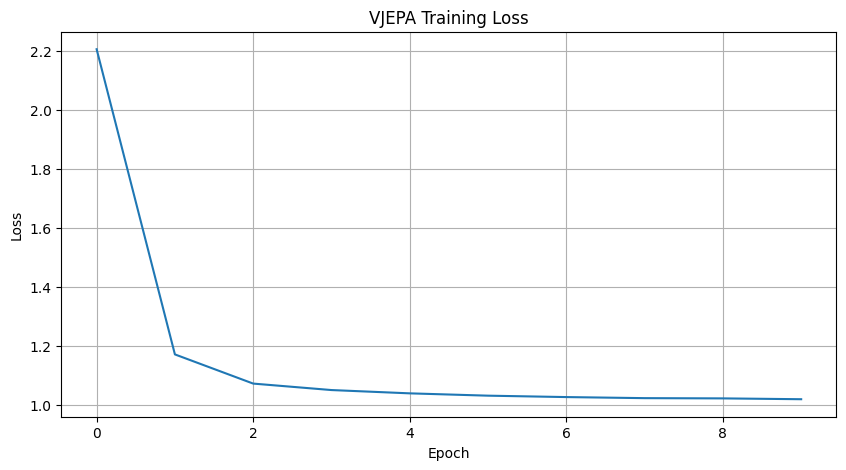

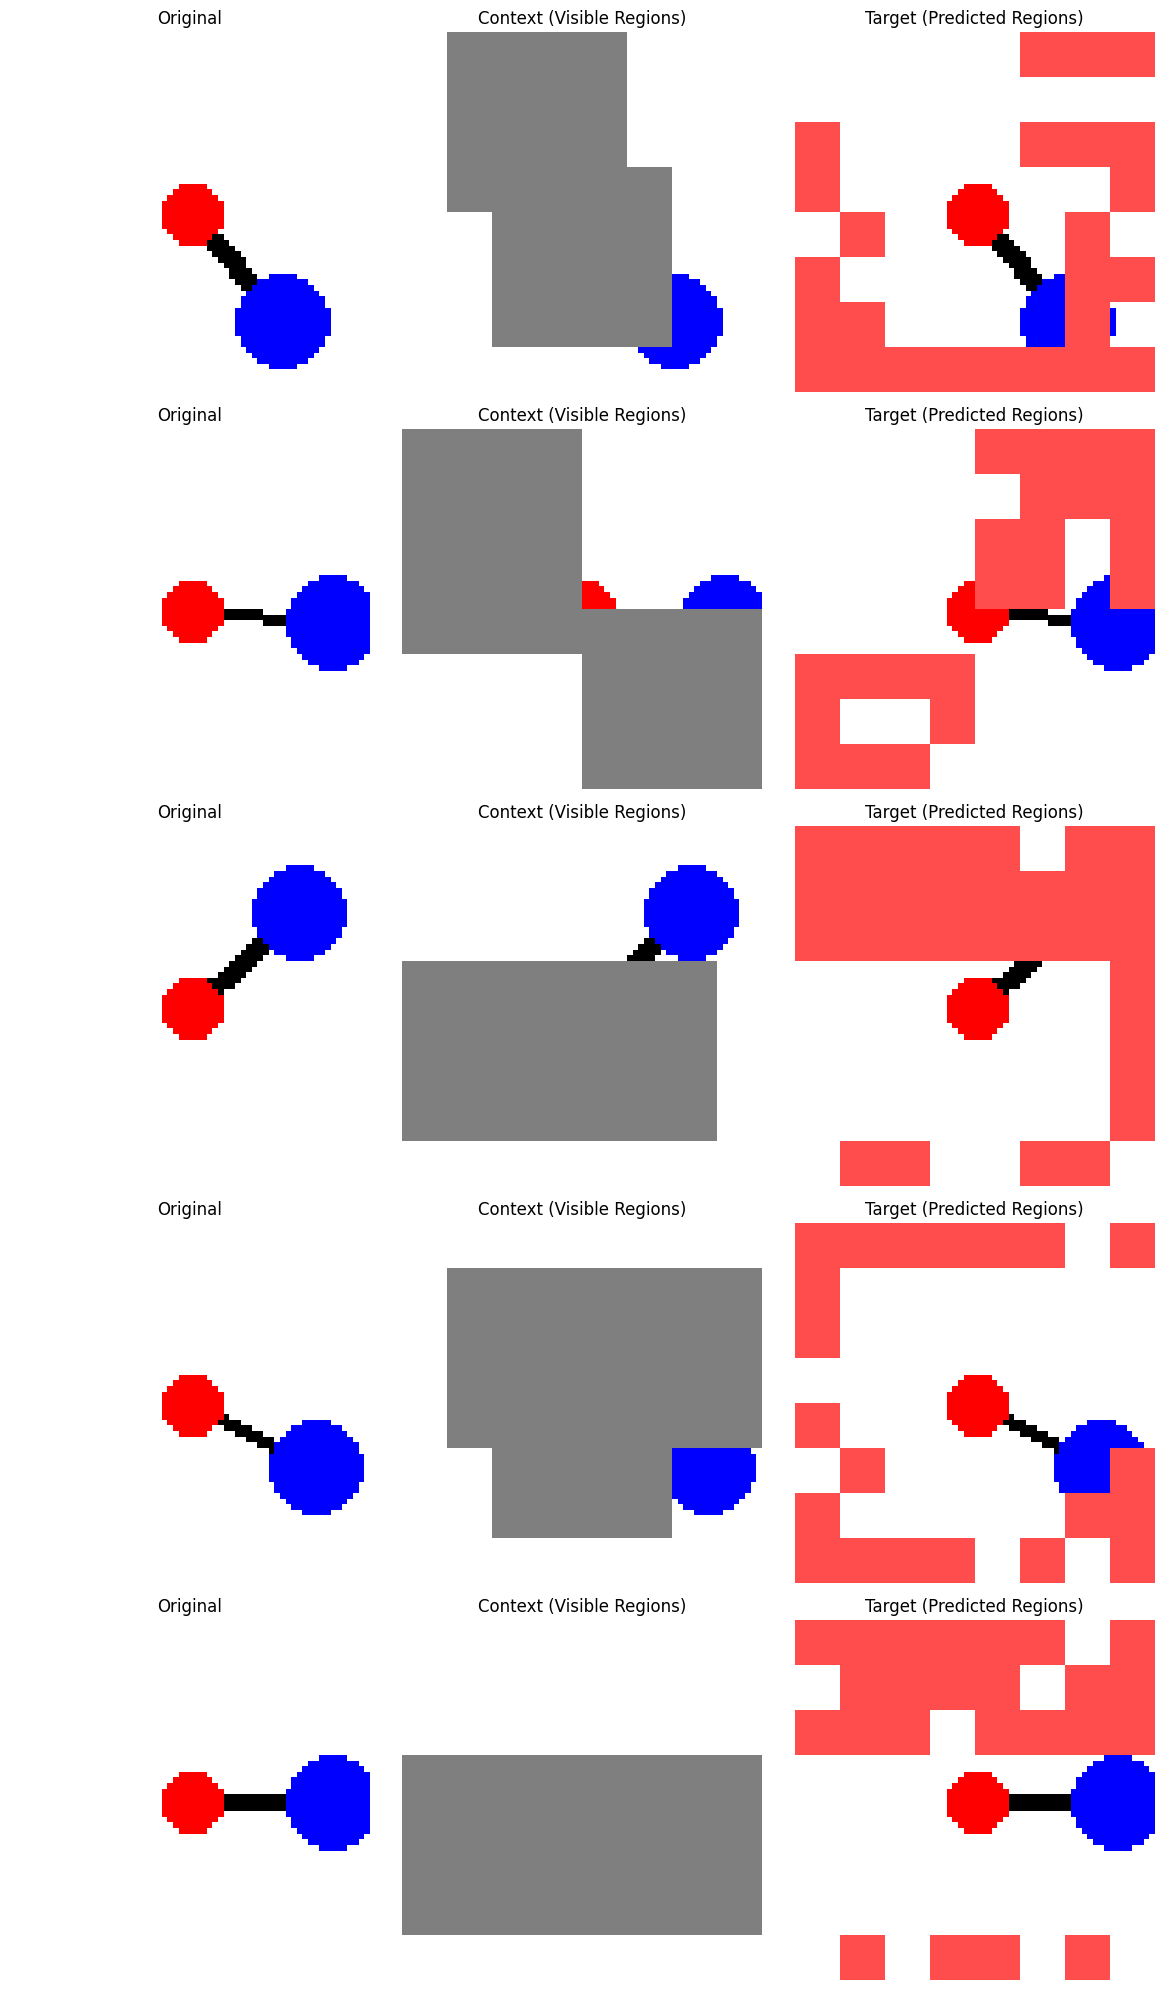

Training completed!


Extracting embeddings:   9%|▉         | 7/79 [00:00<00:01, 62.03it/s]


Latent -> Theta R²: 1.0000, MSE: 0.0001
Latent -> Omega R²: 0.2569, MSE: 9.2201


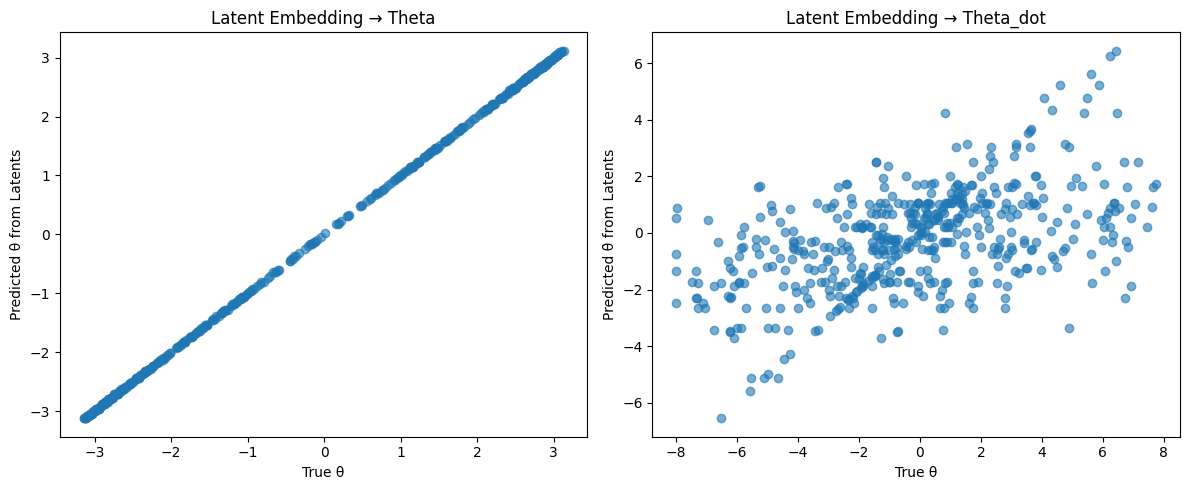

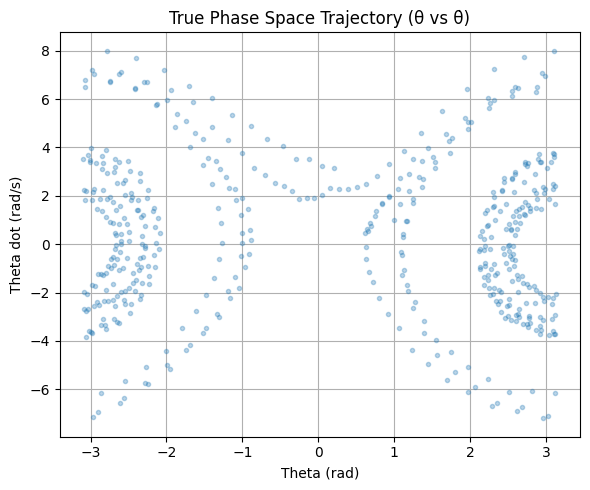

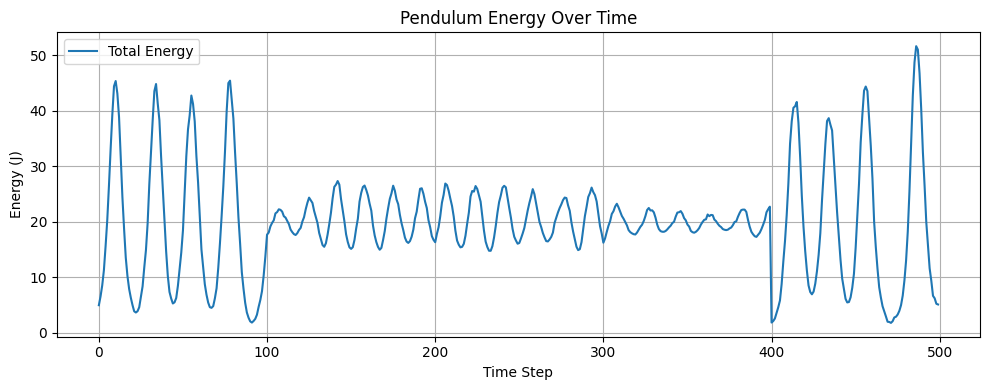

In [28]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gym
from torchvision import transforms
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ============================
# 1. Data Collection and Preparation
# ============================

class PendulumDataset(Dataset):
    def __init__(self, num_episodes=100, episode_length=200, img_size=64, transform=None):
        """
        Dataset for pendulum images from OpenAI Gym

        Args:
            num_episodes: Number of episodes to collect
            episode_length: Length of each episode
            img_size: Size to resize images to
            transform: Additional transforms to apply
        """
        self.img_size = img_size
        self.transform = transform

        # Generate synthetic pendulum images
        self.generate_synthetic_pendulum_data(num_episodes, episode_length)

    def generate_synthetic_pendulum_data(self, num_episodes, episode_length):
        """Generate synthetic pendulum data using PIL"""
        print("Generating synthetic pendulum data...")
        self.images = []

        # Create environment to get pendulum dynamics
        env = gym.make('Pendulum-v1')

        # Set up parameters for drawing pendulum
        img_size = self.img_size
        pendulum_length = img_size * 0.4
        center_x, center_y = img_size // 2, img_size // 2

        self.images = []
        self.labels = []

        for episode in tqdm(range(num_episodes)):
            # Reset environment
            obs = env.reset()
            if isinstance(obs, tuple):
                obs = obs[0]  # New API returns (obs, info)

            # Extract theta from observation
            # In Pendulum-v1, obs[0] = cos(theta), obs[1] = sin(theta)
            theta = np.arctan2(obs[1], obs[0])

            for step in range(episode_length):
                # Take random action
                action = env.action_space.sample()

                # Step the environment
                step_result = env.step(action)

                # Handle different Gym API versions
                if len(step_result) == 4:  # Old API
                    obs, reward, done, _ = step_result
                else:  # New API
                    obs, reward, terminated, truncated, _ = step_result
                    done = terminated or truncated

                # Extract theta from observation
                theta = np.arctan2(obs[1], obs[0])
                omega = obs[2]

                # Draw pendulum image
                # Create a blank image
                img = Image.new('RGB', (img_size, img_size), color='white')
                draw = ImageDraw.Draw(img)

                # Calculate pendulum endpoint
                end_x = int(center_x + pendulum_length * np.sin(theta))
                end_y = int(center_y + pendulum_length * np.cos(theta))

                # Draw pendulum rod
                draw.line([(center_x, center_y), (end_x, end_y)], fill='black', width=3)

                # Draw pivot point
                draw.ellipse(
                    [(center_x-5, center_y-5), (center_x+5, center_y+5)],
                    fill='red'
                )

                # Draw bob
                draw.ellipse(
                    [(end_x-8, end_y-8), (end_x+8, end_y+8)],
                    fill='blue'
                )

                # Convert to numpy array
                img_array = np.array(img)

                # Add to dataset
                self.images.append(img_array)
                self.labels.append((theta, omega))

                if done:
                    break

        env.close()
        self.images = np.array(self.images)
        print(f"Dataset created with {len(self.images)} images")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]

        # Convert to tensor
        img = torch.from_numpy(img).float() / 255.0
        img = img.permute(2, 0, 1)  # Convert to CxHxW format

        if self.transform:
            img = self.transform(img)

        label = torch.tensor(label, dtype=torch.float32)

        return img, label

    def __len__(self):
        return len(self.images)

    # def __getitem__(self, idx):
    #     img = self.images[idx]

    #     # Convert to tensor
    #     img = torch.from_numpy(img).float() / 255.0
    #     img = img.permute(2, 0, 1)  # Convert to CxHxW format

    #     if self.transform:
    #         img = self.transform(img)

    #     return img

# ============================
# 2. VJEPA Architecture
# ============================

class PatchEmbed(nn.Module):
    """
    Image to Patch Embedding
    """
    def __init__(self, img_size=64, patch_size=8, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        self.proj = nn.Conv2d(
            in_chans, embed_dim, kernel_size=patch_size, stride=patch_size
        )

    def forward(self, x):
        B, C, H, W = x.shape
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (B, n_patches, embed_dim)
        return x

class TransformerEncoder(nn.Module):
    """
    Transformer encoder block
    """
    def __init__(self, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4.0):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            layer = nn.TransformerEncoderLayer(
                d_model=embed_dim,
                nhead=num_heads,
                dim_feedforward=int(embed_dim * mlp_ratio),
                batch_first=True,
                norm_first=True
            )
            self.layers.append(layer)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MaskingStrategy:
    """
    Handles masked prediction strategies for JEPA/VJEPA
    """
    def __init__(self, num_patches, mask_ratio=0.75, block_size=4):
        self.num_patches = num_patches
        self.mask_ratio = mask_ratio
        self.block_size = block_size

    def random_masking(self, batch_size):
        """Generate random masks for a batch"""
        n_keep = int(self.num_patches * (1 - self.mask_ratio))

        # For each sample, randomly select patches to keep
        noise = torch.rand(batch_size, self.num_patches, device=device)
        ids_shuffle = torch.argsort(noise, dim=1)
        ids_restore = torch.argsort(ids_shuffle, dim=1)

        # Determine which patches to keep
        mask = torch.ones([batch_size, self.num_patches], device=device)
        mask[:, :n_keep] = 0
        # Unshuffle to get the mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return mask.bool()  # masked positions are True

    def block_masking(self, batch_size):
        """Generate block-wise masks"""
        grid_size = int(np.sqrt(self.num_patches))

        # Create empty masks
        masks = torch.zeros(batch_size, self.num_patches, device=device)

        for b in range(batch_size):
            # Number of blocks to mask
            n_blocks = int((self.num_patches * self.mask_ratio) / (self.block_size**2))

            # Randomly choose block starting positions
            for _ in range(n_blocks):
                # Choose random top-left corner for block
                h_start = np.random.randint(0, grid_size - self.block_size + 1)
                w_start = np.random.randint(0, grid_size - self.block_size + 1)

                # Mask all patches in this block
                for h in range(h_start, h_start + self.block_size):
                    for w in range(w_start, w_start + self.block_size):
                        patch_idx = h * grid_size + w
                        masks[b, patch_idx] = 1

        return masks.bool()  # masked positions are True

class VJEPA(nn.Module):
    """
    Vision-based Joint Embedding Predictive Architecture
    """
    def __init__(
        self,
        img_size=64,
        patch_size=8,
        in_chans=3,
        embed_dim=768,
        depth=12,
        num_heads=12,
        decoder_embed_dim=512,
        decoder_depth=8,
        decoder_num_heads=16,
        mlp_ratio=4.0,
        prediction_head_dim=384
    ):
        super().__init__()

        # Patch embedding
        self.patch_embed = PatchEmbed(
            img_size=img_size,
            patch_size=patch_size,
            in_chans=in_chans,
            embed_dim=embed_dim
        )

        # Number of patches
        self.num_patches = self.patch_embed.n_patches

        # Position embeddings
        self.pos_embed = nn.Parameter(
            torch.zeros(1, self.num_patches, embed_dim)
        )

        # Context encoder (f_θ)
        self.context_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio
        )

        # Target encoder (g_ϕ)
        self.target_encoder = TransformerEncoder(
            embed_dim=embed_dim,
            depth=depth,
            num_heads=num_heads,
            mlp_ratio=mlp_ratio
        )

        # Predictor network
        self.predictor = nn.Sequential(
            nn.Linear(embed_dim, prediction_head_dim),
            nn.GELU(),
            nn.Linear(prediction_head_dim, embed_dim)
        )

        # Masking strategy
        self.masking = MaskingStrategy(self.num_patches)

        # Initialize weights
        self._init_weights()

    def _init_weights(self):
        # Initialize position embeddings
        nn.init.normal_(self.pos_embed, std=0.02)

        # Initialize projection layers
        self.apply(self._init_weights_layer)

    def _init_weights_layer(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    # def forward_context(self, imgs, context_mask):
    #     """Process the context (visible) regions"""
    #     # Get patch embeddings
    #     x = self.patch_embed(imgs)

    #     # Add position embeddings
    #     x = x + self.pos_embed

    #     # Get unmasked patches
    #     unmasked_indices = ~context_mask
    #     x_unmasked = x[unmasked_indices].reshape(imgs.shape[0], -1, x.shape[-1])

    #     # Encode context
    #     context_feats = self.context_encoder(x_unmasked)

    #     return context_feats
    def forward_context(self, imgs, context_mask):
      """Process the context (visible) regions"""
      # Get patch embeddings
      x = self.patch_embed(imgs)  # [B, num_patches, embed_dim]

      # Add positional embeddings
      x = x + self.pos_embed  # [B, num_patches, embed_dim]

      B, N, D = x.shape
      unmasked_indices = ~context_mask  # [B, num_patches]

      # Collect unmasked patches per sample
      x_unmasked = []

      for i in range(B):
          patches = x[i][unmasked_indices[i]]  # [num_unmasked_i, D]

          # Pad to the max number of patches in the batch
          num_unmasked = patches.shape[0]
          padded = F.pad(patches, (0, 0, 0, N - num_unmasked))  # [N, D]
          x_unmasked.append(padded)

      x_unmasked = torch.stack(x_unmasked)  # [B, N, D]

      # Optionally, create attention masks if Transformer should ignore padded tokens

      # Encode context
      context_feats = self.context_encoder(x_unmasked)  # [B, N, D]

      return context_feats


    def forward_target(self, imgs, target_mask):
        """Process the target (masked) regions"""
        # Get patch embeddings
        x = self.patch_embed(imgs)  # [B, num_patches, embed_dim]

        # Add positional embeddings
        x = x + self.pos_embed

        B, N, D = x.shape
        masked_indices = target_mask  # [B, num_patches]

        x_masked = []

        for i in range(B):
            patches = x[i][masked_indices[i]]  # [num_masked_i, D]

            # Pad to full length N
            num_masked = patches.shape[0]
            padded = F.pad(patches, (0, 0, 0, N - num_masked))  # [N, D]
            x_masked.append(padded)

        x_masked = torch.stack(x_masked)  # [B, N, D]

        # Encode masked regions (targets)
        target_feats = self.target_encoder(x_masked)

        return target_feats


    def forward(self, imgs):
        """
        Forward pass of VJEPA

        Args:
            imgs: Batch of images [B, C, H, W]

        Returns:
            loss: VJEPA loss value
            pred: Predicted embeddings
            target: Target embeddings
        """
        B = imgs.shape[0]

        # Generate masks for context and target
        context_mask = self.masking.block_masking(B)
        target_mask = self.masking.random_masking(B)

        # Ensure context and target don't overlap
        overlap_mask = context_mask & target_mask
        target_mask = target_mask & ~overlap_mask

        # Forward pass through context encoder
        context_feats = self.forward_context(imgs, context_mask)

        # Forward pass through target encoder
        with torch.no_grad():  # Stop gradient for target encoder
            target_feats = self.forward_target(imgs, target_mask)

        # Generate predictions from context
        pred = self.predictor(context_feats)

        # Compute loss
        loss = F.mse_loss(pred, target_feats)

        return loss, pred, target_feats

# ============================
# 3. Training Function
# ============================

def train_vjepa(model, train_loader, optimizer, num_epochs=100, log_interval=10):
    """Train the VJEPA model"""

    model.train()
    losses = []

    print("Starting training...")
    for epoch in range(num_epochs):
        epoch_loss = 0

        with tqdm(train_loader, unit="batch") as tepoch:
            for i, (imgs, _) in enumerate(tepoch):
                tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")

                # Move to device
                imgs = imgs.to(device)

                # Forward pass
                loss, _, _ = model(imgs)

                # Backward pass
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Update metrics
                epoch_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())

                # Log progress
                if i % log_interval == 0 and i > 0:
                    print(f"Epoch {epoch+1}, Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}")

        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)

        print(f"Epoch {epoch+1} completed, Avg Loss: {avg_loss:.4f}")

        # Save checkpoint
        if (epoch + 1) % 10 == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
            }, f"vjepa_pendulum_epoch_{epoch+1}.pt")

    return losses

# ============================
# 4. Visualization Functions
# ============================
def visualize_reconstructions(model, dataset, num_samples=5):
    """Visualize original images and their reconstructions"""
    model.eval()

    # Create a dataloader with batch size equal to num_samples
    loader = DataLoader(dataset, batch_size=num_samples, shuffle=True)
    imgs, _ = next(iter(loader))  # <-- FIXED: unpack the tuple
    imgs = imgs.to(device)

    # Get reconstructions
    with torch.no_grad():
        # Generate masks
        B = imgs.shape[0]
        context_mask = model.masking.block_masking(B)
        target_mask = model.masking.random_masking(B)

        # Ensure no overlap
        overlap_mask = context_mask & target_mask
        target_mask = target_mask & ~overlap_mask

        # Get features
        context_feats = model.forward_context(imgs, context_mask)
        pred = model.predictor(context_feats)

    # Visualize the results
    plt.figure(figsize=(12, 4 * num_samples))

    for i in range(num_samples):
        # Original image
        plt.subplot(num_samples, 3, i * 3 + 1)
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        plt.imshow(img)
        plt.title("Original")
        plt.axis('off')

        # Masked image (context)
        plt.subplot(num_samples, 3, i * 3 + 2)
        masked_img = imgs[i].clone().cpu()

        grid_size = int(np.sqrt(model.num_patches))
        mask_reshaped = context_mask[i].reshape(1, 1, grid_size, grid_size).float()
        mask_upsampled = F.interpolate(
            mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            masked_img[c][mask_upsampled.bool()] = 0.5  # Gray out masked areas

        plt.imshow(masked_img.permute(1, 2, 0).numpy())
        plt.title("Context (Visible Regions)")
        plt.axis('off')

        # Target image (highlight predicted regions)
        plt.subplot(num_samples, 3, i * 3 + 3)
        target_img = imgs[i].clone().cpu()

        target_mask_reshaped = target_mask[i].reshape(1, 1, grid_size, grid_size).float()
        target_mask_upsampled = F.interpolate(
            target_mask_reshaped,
            size=(imgs.shape[2], imgs.shape[3]),
            mode='nearest'
        ).squeeze()

        for c in range(3):
            if c == 0:  # Red channel
                target_img[c][target_mask_upsampled.bool()] = 1.0
            else:
                target_img[c][target_mask_upsampled.bool()] = 0.3

        plt.imshow(target_img.permute(1, 2, 0).numpy())
        plt.title("Target (Predicted Regions)")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig('vjepa_reconstructions.png')
    plt.show()


def plot_training_loss(losses):
    """Plot training loss over epochs"""
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('VJEPA Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.savefig('vjepa_training_loss.png')
    plt.show()

# ============================
# 5. Main Execution
# ============================

def main():
    # Configuration
    batch_size = 32
    img_size = 64
    patch_size = 8
    embed_dim = 384  # Smaller for faster training
    depth = 6  # Smaller depth for faster training
    num_heads = 6
    prediction_head_dim = 192
    learning_rate = 1e-4
    num_epochs = 10

    # Create dataset
    dataset = PendulumDataset(num_episodes=50, episode_length=100, img_size=img_size)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)  # Set num_workers=0 for compatibility

    # Create model
    model = VJEPA(
        img_size=img_size,
        patch_size=patch_size,
        in_chans=3,
        embed_dim=embed_dim,
        depth=depth,
        num_heads=num_heads,
        decoder_embed_dim=embed_dim // 2,
        decoder_depth=4,
        decoder_num_heads=num_heads,
        mlp_ratio=4.0,
        prediction_head_dim=prediction_head_dim
    ).to(device)

    # Create optimizer
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Train model
    losses = train_vjepa(model, train_loader, optimizer, num_epochs=num_epochs)

    # Plot training loss
    plot_training_loss(losses)

    # Visualize reconstructions
    visualize_reconstructions(model, dataset)

    # Save final model
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, "vjepa_pendulum_final.pt")

    print("Training completed!")

    analyze_vjepa_latent_phase_relation(model,dataset )
    plot_true_phase_space(dataset)
    plot_energy_conservation(dataset)

if __name__ == "__main__":
    main()

## Lagrangian

In [10]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def analyze_lagrangian_phase_space(model, g=9.81, l=1.0):
    """
    Analyze the learned Lagrangian by evaluating the Euler-Lagrange dynamics
    over a grid of (theta, theta_dot) values.

    Args:
        model: Trained LagrangianNN model
        g: gravitational constant
        l: pendulum length
    """
    # Phase space grid
    theta_vals = np.linspace(-3*np.pi, 3*np.pi, 100)
    omega_vals = np.linspace(-10, 10, 100)
    theta_grid, omega_grid = np.meshgrid(theta_vals, omega_vals)

    # Flatten for batch prediction
    theta_flat = torch.tensor(theta_grid.flatten(), dtype=torch.float32).unsqueeze(1)
    omega_flat = torch.tensor(omega_grid.flatten(), dtype=torch.float32).unsqueeze(1)
    theta_flat.requires_grad = True
    omega_flat.requires_grad = True

    # Forward pass
    L = model(theta_flat, omega_flat)

    # First-order derivatives
    dL_dtheta, dL_domega = torch.autograd.grad(L.sum(), (theta_flat, omega_flat), create_graph=True)

    # Second-order derivatives
    d2L_dtheta2, d2L_domega2 = torch.autograd.grad(dL_domega.sum(), (theta_flat, omega_flat), create_graph=True)

    # Predicted angular acceleration (Euler-Lagrange output)
    eps = 1e-6
    denom = d2L_domega2 + eps
    alpha_pred = (dL_dtheta - d2L_dtheta2 * omega_flat) / denom

    # Convert to NumPy for plotting
    alpha_pred_np = alpha_pred.detach().numpy().reshape(theta_grid.shape)
    alpha_true_np = - (g / l) * np.sin(theta_grid)
    error_np = np.abs(alpha_pred_np - alpha_true_np)

    # ========= 1. Phase Portrait (Streamplot) ==========
    plt.figure(figsize=(10, 6))
    plt.streamplot(theta_vals, omega_vals,
                   omega_grid, alpha_pred_np,
                   density=1.0, color='blue')
    plt.title("Phase Portrait from Learned Lagrangian")
    plt.xlabel("Theta (rad)")
    plt.ylabel("Theta_dot (rad/s)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ========= 2. Error Heatmap ==========
    plt.figure(figsize=(8, 6))
    contour = plt.contourf(theta_grid, omega_grid, error_np, levels=50, cmap='hot')
    plt.colorbar(contour, label='|α_pred - α_true|')
    plt.title("Acceleration Error Heatmap (Euler-Lagrange Residual)")
    plt.xlabel("Theta (rad)")
    plt.ylabel("Theta_dot (rad/s)")
    plt.tight_layout()
    plt.show()

    # ========= 3. Lagrangian Surface Plot ==========
    with torch.no_grad():
        L_np = L.detach().numpy().reshape(theta_grid.shape)

    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(theta_grid, omega_grid, L_np, cmap='viridis', edgecolor='none')
    ax.set_title("Learned Lagrangian Surface: L(θ, θ̇)")
    ax.set_xlabel("Theta (rad)")
    ax.set_ylabel("Theta_dot (rad/s)")
    ax.set_zlabel("Lagrangian L")
    plt.tight_layout()
    plt.show()


In [11]:
import math
import random

# Pendulum parameters and constants
g = 9.81   # gravitational acceleration (m/s^2)
l = 1.0    # pendulum length (m)
dt = 0.05  # time step for simulation (s)

def simulate_pendulum(theta0, omega0, steps=100):
    """Simulate pendulum motion given initial angle theta0 and angular velocity omega0."""
    theta, omega = theta0, omega0
    trajectory = []
    for _ in range(steps):
        # Compute angular acceleration from the pendulum equation: θ¨ = - (g/l) * sin(θ)
        alpha = - (g/l) * math.sin(theta)
        # Record the state and acceleration (θ, θ̇, θ̈)
        trajectory.append((theta, omega, alpha))
        # Update the state using semi-implicit Euler integration
        omega += alpha * dt          # update angular velocity
        theta += omega * dt          # update angle
    return trajectory

# Generate training data from multiple trajectories
train_data = []
initial_conditions = [(1.5, -0.5),  # (initial angle in rad, initial angular velocity in rad/s)
                      (2.0,  0.0),
                      (0.5,  1.0),
                      (-1.0, 0.5)]
for theta0, omega0 in initial_conditions:
    train_data += simulate_pendulum(theta0, omega0, steps=50)

# Shuffle the collected data points
random.shuffle(train_data)
print(f"Generated {len(train_data)} data points from {len(initial_conditions)} trajectories.")
# Each data point is a tuple (theta, theta_dot, theta_ddot)
print("Sample data point:", train_data[0])

Generated 200 data points from 4 trajectories.
Sample data point: (1.1574857144172364, -2.427265182933488, -8.983960313549117)


In [12]:
import torch

# Convert the training data into PyTorch tensors
train_data_t = torch.tensor(train_data, dtype=torch.float32)
theta_train = train_data_t[:, 0:1]   # θ (angle) column, shape [N, 1]
omega_train = train_data_t[:, 1:2]   # θ̇ (angular velocity) column, shape [N, 1]
alpha_train = train_data_t[:, 2:3]   # θ̈ (angular acceleration) column, shape [N, 1]

# Verify shapes and a sample
print(theta_train.shape, omega_train.shape, alpha_train.shape)
print("First training sample (theta, omega, alpha):", theta_train[0].item(), omega_train[0].item(), alpha_train[0].item())



torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 1])
First training sample (theta, omega, alpha): 1.1574857234954834 -2.427265167236328 -8.983960151672363


In [14]:
# Define the Lagrangian Neural Network (a 2-layer MLP)
class LagrangianNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(2, 64),    # input: (theta, omega) -> 64 hidden units
            torch.nn.Softplus(),
            torch.nn.Linear(64, 64),   # second hidden layer
            torch.nn.Softplus(),
            torch.nn.Linear(64, 1)     # output a single value L
        )
    def forward(self, theta, omega):
        # Concatenate theta and omega for the MLP input
        x = torch.cat([theta, omega], dim=1)
        return self.model(x)

# Initialize the model and optimizer
model_l = LagrangianNN()
optimizer = torch.optim.Adam(model_l.parameters(), lr=1e-3)


In [16]:
# Training the model using the Euler-Lagrange consistency loss
epochs = 100
for epoch in range(1, epochs+1):
    # Enable gradient tracking for input tensors
    theta_train.requires_grad = True
    omega_train.requires_grad = True

    # Step 1: Forward pass to get Lagrangian values
    L_pred = model_l(theta_train, omega_train)           # L_pred is shape [N,1]

    # Step 2: First derivatives w.rt theta and omega
    L_sum = L_pred.sum()  # sum the outputs to conveniently compute batch gradients at once
    dL_dtheta, dL_domega = torch.autograd.grad(L_sum, (theta_train, omega_train), create_graph=True)
    # dL_dtheta and dL_domega are each shape [N,1], containing ∂L/∂θ and ∂L/∂θ̇ for each sample

    # Step 3: Second derivatives (derivatives of dL/domega)
    # We differentiate the sum of dL/domega values to get second-order terms
    d2L_dtheta2, d2L_domega2 = torch.autograd.grad(dL_domega.sum(), (theta_train, omega_train), create_graph=True)
    # d2L_dtheta2 = ∂(∂L/∂ω)/∂θ (mixed second derivative), d2L_domega2 = ∂(∂L/∂ω)/∂ω (second derivative w.rt ω)

    # Step 4: Compute predicted acceleration from Euler-Lagrange formula
    # Avoid division by zero by adding a small epsilon to the denominator if necessary (for numerical stability)
    eps = 1e-6
    denom = d2L_domega2 + eps
    alpha_pred = (dL_dtheta - d2L_dtheta2 * omega_train) / denom  # predicted θ̈

    # Step 5: Compute MSE loss between predicted and true accelerations
    loss = torch.mean((alpha_pred - alpha_train)**2)

    # Step 6: Backpropagation and optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print training progress occasionally
    if epoch % 20 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}: training MSE loss = {loss.item():.6f}")



Epoch   1: training MSE loss = 68.252449
Epoch  20: training MSE loss = 68.205147
Epoch  40: training MSE loss = 68.197380
Epoch  60: training MSE loss = 68.195976
Epoch  80: training MSE loss = 68.195427
Epoch 100: training MSE loss = 68.195023


In [17]:

# Simulate a new pendulum trajectory for testing (not part of training data)
test_traj = simulate_pendulum(theta0=1.0, omega0=0.5, steps=50)
theta_test = torch.tensor([s[0] for s in test_traj], dtype=torch.float32).unsqueeze(1)
omega_test = torch.tensor([s[1] for s in test_traj], dtype=torch.float32).unsqueeze(1)
alpha_true = [s[2] for s in test_traj]  # true accelerations for reference

# Use the trained model to predict accelerations for each state in the test trajectory
theta_test.requires_grad = True
omega_test.requires_grad = True
L_test = model_l(theta_test, omega_test)
dL_dtheta_test, dL_domega_test = torch.autograd.grad(L_test.sum(), (theta_test, omega_test), create_graph=True)
d2L_dtheta2_test, d2L_domega2_test = torch.autograd.grad(dL_domega_test.sum(), (theta_test, omega_test), create_graph=True)
alpha_pred = (dL_dtheta_test - d2L_dtheta2_test * omega_test) / (d2L_domega2_test + 1e-6)

# Compare actual vs predicted accelerations for a few points
print("\nTest trajectory: Actual vs Predicted accelerations (first 5 time steps)")
for i in range(5):
    print(f"t={i*dt:.2f}s: actual α = {alpha_true[i]:.4f},  predicted α = {alpha_pred[i].item():.4f}")




Test trajectory: Actual vs Predicted accelerations (first 5 time steps)
t=0.00s: actual α = -8.2548,  predicted α = 1.1184
t=0.05s: actual α = -8.2779,  predicted α = 1.0719
t=0.10s: actual α = -8.1908,  predicted α = 1.0369
t=0.15s: actual α = -7.9866,  predicted α = 1.0102
t=0.20s: actual α = -7.6505,  predicted α = 0.9837


In [18]:
# Visualize by simulating the pendulum using the learned model's predictions
theta_sim, omega_sim = 1.0, 0.5  # initial state for simulation
predicted_angles = []
true_angles = []
for t in range(50):
    # true physics update (for reference)
    alpha_true_t = - (g/l) * math.sin(theta_sim)
    true_angles.append(theta_sim)
    # model predicted acceleration
    theta_t = torch.tensor([[theta_sim]], requires_grad=True)
    omega_t = torch.tensor([[omega_sim]], requires_grad=True)
    L_val = model_l(theta_t, omega_t)
    dL_dtheta_val, dL_domega_val = torch.autograd.grad(L_val, (theta_t, omega_t), create_graph=True)
    d2L_dtheta2_val, d2L_domega2_val = torch.autograd.grad(dL_domega_val, (theta_t, omega_t), create_graph=True)
    alpha_pred_val = (dL_dtheta_val - d2L_dtheta2_val * omega_t) / (d2L_domega2_val + 1e-6)
    alpha_pred_val = alpha_pred_val.item()
    predicted_angles.append(theta_sim)
    # Update state using predicted acceleration
    omega_sim += alpha_pred_val * dt
    theta_sim += omega_sim * dt


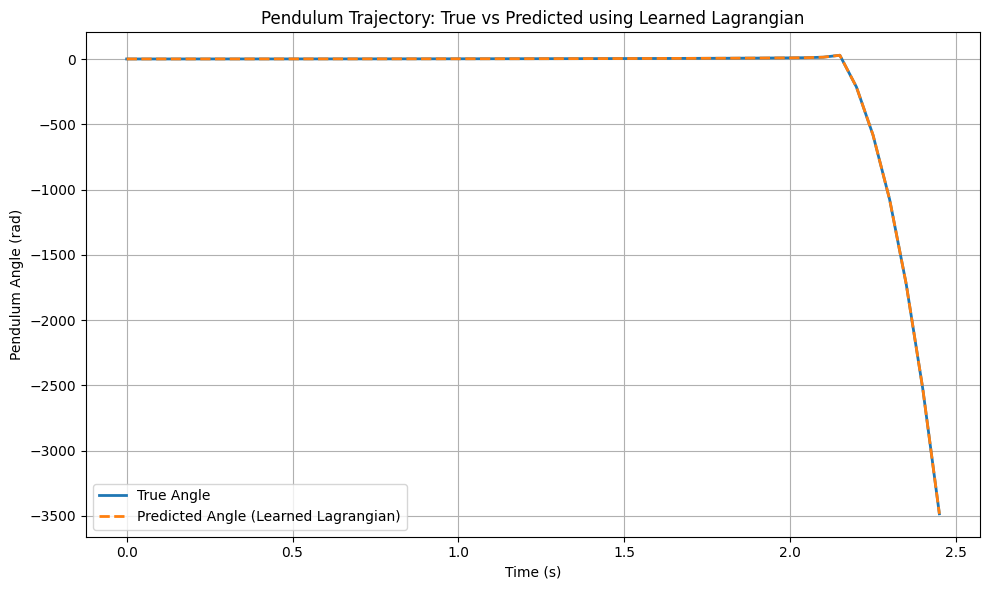

In [19]:
import matplotlib.pyplot as plt

# Generate time steps
time_steps = [i * dt for i in range(len(true_angles))]

# Plot true vs predicted pendulum angles
plt.figure(figsize=(10, 6))
plt.plot(time_steps, true_angles, label='True Angle', linewidth=2)
plt.plot(time_steps, predicted_angles, label='Predicted Angle (Learned Lagrangian)', linestyle='--', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Pendulum Angle (rad)')
plt.title('Pendulum Trajectory: True vs Predicted using Learned Lagrangian')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



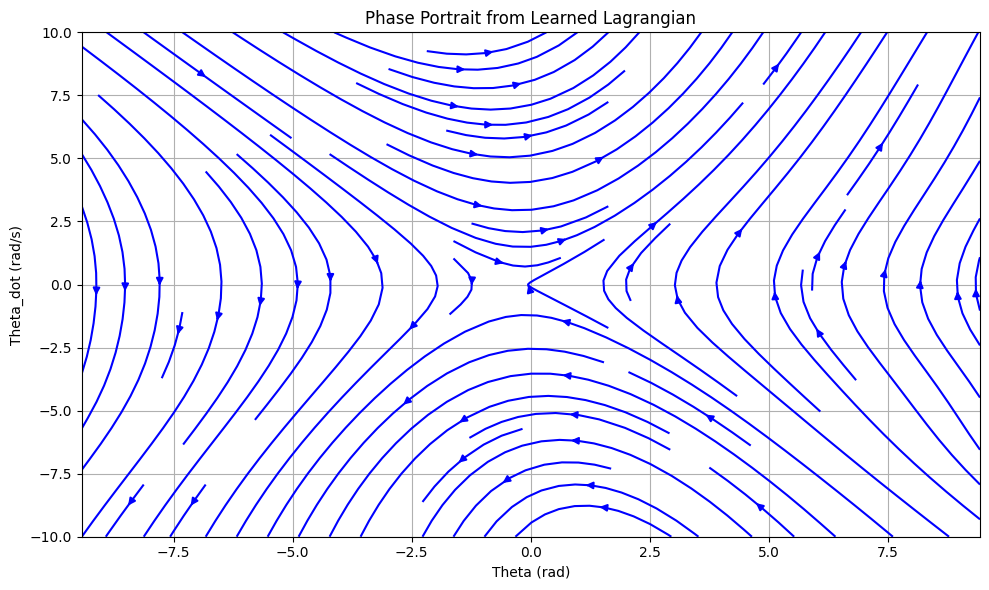

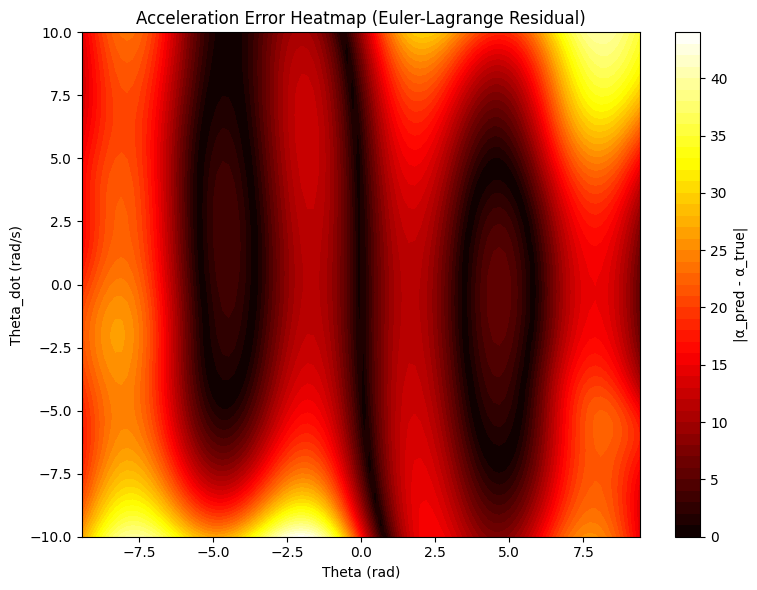

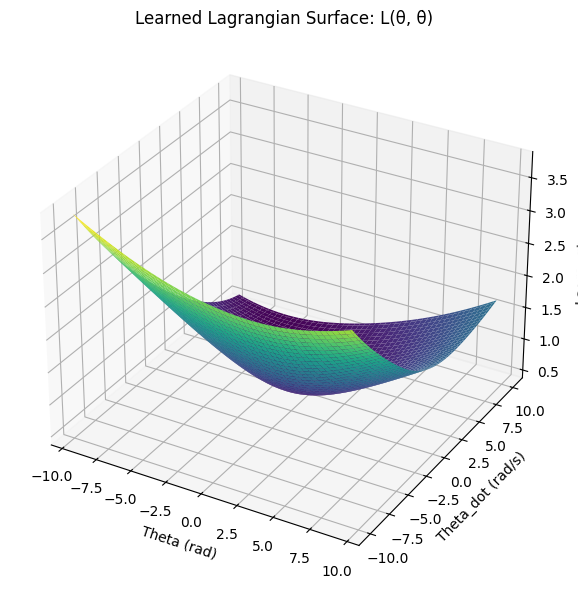

In [20]:
analyze_lagrangian_phase_space(model_l)

Epoch 50: Loss = 20.237434
Epoch 100: Loss = 7.484986
Epoch 150: Loss = 3.660862
Epoch 200: Loss = 2.030427
Epoch 250: Loss = 1.086594
Epoch 300: Loss = 0.623685


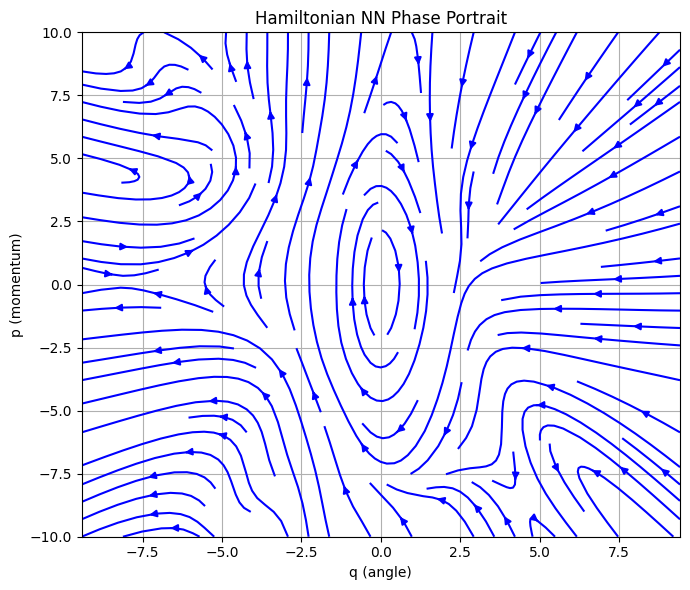

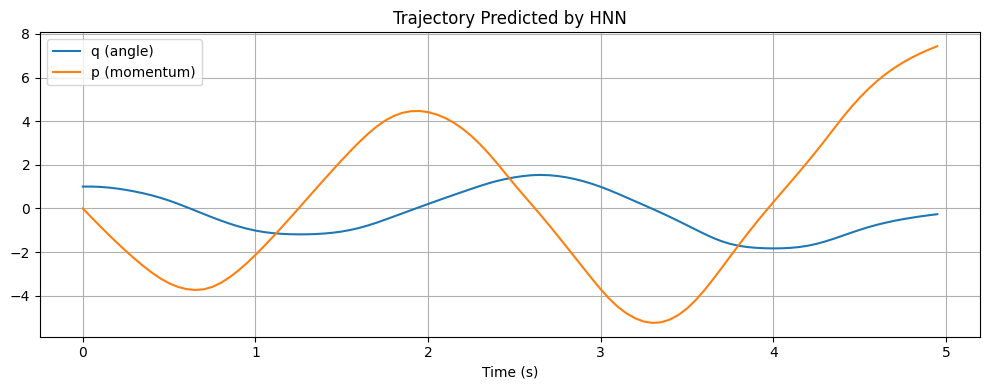

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ========== 1. Data Generation ==========

def simulate_pendulum_hnn(q0, p0, steps=100, dt=0.05, g=9.81, l=1.0):
    q, p = q0, p0
    data = []
    for _ in range(steps):
        dq = p / l**2
        dp = -g * l * np.sin(q)
        data.append((q, p, dq, dp))
        p += dp * dt
        q += dq * dt
    return data

# Generate dataset
initial_conditions = [(1.0, 0.0), (2.0, 0.0), (-1.0, 0.5), (0.5, -0.5)]
data = []
for q0, p0 in initial_conditions:
    data += simulate_pendulum_hnn(q0, p0, steps=50)

data = np.array(data)
np.random.shuffle(data)

q_data = torch.tensor(data[:, 0:1], dtype=torch.float32)
p_data = torch.tensor(data[:, 1:2], dtype=torch.float32)
dqdt_data = torch.tensor(data[:, 2:3], dtype=torch.float32)
dpdt_data = torch.tensor(data[:, 3:4], dtype=torch.float32)

x_train = torch.cat([q_data, p_data], dim=1).to(device)
dxdt_true = torch.cat([dqdt_data, dpdt_data], dim=1).to(device)

# ========== 2. HNN Architecture ==========

class HamiltonianNN(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

    def time_derivative(self, x):
        x = x.requires_grad_(True)
        H = self.forward(x)
        grad = torch.autograd.grad(H.sum(), x, create_graph=True)[0]
        dqdt = grad[:, 1:2]  # ∂H/∂p
        dpdt = -grad[:, 0:1] # -∂H/∂q
        return torch.cat([dqdt, dpdt], dim=1)

# ========== 3. Training ==========

model = HamiltonianNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(1, 301):
    optimizer.zero_grad()
    dxdt_pred = model.time_derivative(x_train)
    loss = ((dxdt_pred - dxdt_true)**2).mean()
    loss.backward()
    optimizer.step()
    if epoch % 50 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.6f}")

# ========== 4. Phase Portrait ==========

def plot_phase_portrait(model, xrange=3*np.pi, prange=10, gridsize=100):
    q_vals = np.linspace(-xrange, xrange, gridsize)
    p_vals = np.linspace(-prange, prange, gridsize)
    Q, P = np.meshgrid(q_vals, p_vals)
    inputs = torch.tensor(
        np.stack([Q.ravel(), P.ravel()], axis=1),
        dtype=torch.float32,
        requires_grad=True  # ← critical line
    ).to(device)

    dxdt = model.time_derivative(inputs).detach().cpu().numpy()
    dqdt = dxdt[:, 0].reshape(gridsize, gridsize)
    dpdt = dxdt[:, 1].reshape(gridsize, gridsize)

    plt.figure(figsize=(7, 6))
    plt.streamplot(Q, P, dqdt, dpdt, density=1.0, color='blue')
    plt.title("Hamiltonian NN Phase Portrait")
    plt.xlabel("q (angle)")
    plt.ylabel("p (momentum)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_phase_portrait(model)

# ========== 5. Trajectory Prediction ==========

def predict_trajectory(model, q0=1.0, p0=0.0, steps=100, dt=0.05):
    qs, ps = [], []
    q, p = q0, p0
    for _ in range(steps):
        qs.append(q)
        ps.append(p)
        x = torch.tensor([[q, p]], dtype=torch.float32).to(device)
        dqdt, dpdt = model.time_derivative(x).detach().cpu().numpy()[0]
        p += dpdt * dt
        q += dqdt * dt
    return qs, ps

qs, ps = predict_trajectory(model, q0=1.0, p0=0.0)
time = np.arange(len(qs)) * 0.05

plt.figure(figsize=(10, 4))
plt.plot(time, qs, label='q (angle)')
plt.plot(time, ps, label='p (momentum)')
plt.title("Trajectory Predicted by HNN")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
